In [215]:
from Bio import AlignIO
import os
from pathlib import Path
import blosum
from Bio.Align import substitution_matrices
from Bio.Align import PairwiseAligner
import numpy

In [227]:
from matplotlib import pyplot
import matplotlib
%matplotlib inline
matplotlib.style.use("ggplot")
matplotlib.rcParams["figure.figsize"] = (30, 30)

In [307]:
alignment_path = Path(".") / "Alignments"

In [308]:
alignments = {x.split(".")[0]: AlignIO.read(alignment_path / x, format="clustal") for x in os.listdir("Alignments")}

In [309]:
alignments

{'GABRA1': <<class 'Bio.Align.MultipleSeqAlignment'> instance (10 records of length 479) at 18e84f80f40>,
 'GABRA2': <<class 'Bio.Align.MultipleSeqAlignment'> instance (14 records of length 538) at 18e84f80a30>,
 'GABRA3': <<class 'Bio.Align.MultipleSeqAlignment'> instance (10 records of length 493) at 18e86171b80>,
 'GABRA4': <<class 'Bio.Align.MultipleSeqAlignment'> instance (10 records of length 570) at 18e84f11a90>,
 'GABRA5': <<class 'Bio.Align.MultipleSeqAlignment'> instance (10 records of length 466) at 18e84f11c70>,
 'GABRA6': <<class 'Bio.Align.MultipleSeqAlignment'> instance (11 records of length 467) at 18e85566820>,
 'GABRB1': <<class 'Bio.Align.MultipleSeqAlignment'> instance (10 records of length 488) at 18e85566100>,
 'GABRB2': <<class 'Bio.Align.MultipleSeqAlignment'> instance (10 records of length 524) at 18e85666af0>,
 'GABRB3': <<class 'Bio.Align.MultipleSeqAlignment'> instance (10 records of length 561) at 18e85083d00>,
 'GABRD': <<class 'Bio.Align.MultipleSeqAlignm

In [310]:
def prepare_matrix(name):
    """
    Adapted substitution matrix:
    Maximal number was substracted from all the values, bringing them to negative values with maximum of 0.
    Then the values were reveresed so the least likely change is scored the highest.
    Finally, all the diagonal values (synonimous change) were changed to 0.
    Scaling everything (except indels) to get values between 0 and 1.
    Setting insertion to 2 and deletion to 3.
    Setting - => - to -1.
    """
    matrix = substitution_matrices.load(name)

    matrix = -(matrix - matrix.max())
    numpy.fill_diagonal(matrix, 0)
    # Temporary setting of the indels to 0
    matrix[-1,:] = 0
    matrix[:, -1] = 0
    # Scaling
    matrix = matrix / matrix.max()
    # Setting indels
    matrix[-1,:] = -0.5
    matrix[:, -1] = -1
    matrix[-1, -1] = -1.5
    return matrix

In [311]:
comparisons = {}
alternative_alignments = {}
aligner = PairwiseAligner()
matrix = prepare_matrix("BLOSUM90")
aligner.substitution_matrix = substitution_matrices.load("BLOSUM90")

for key, alignment in alignments.items():
    species_raw = numpy.array(["_".join(seq.id.split("|")[1].split("_")[1:]) for seq in alignment])
    species_unique, counts = numpy.unique(species_raw, return_counts=True)

    if len(species_unique) > 1: # Only compare if there is a comparison to be made
        i_homo = int(numpy.where(species_raw == "Homo_sapiens")[0][0])
        reference_seq = alignment[i_homo]

        if (counts > 1).any(): # We have duplicates for the same species so we transfer all that are not maximally similar to the reference into the alternative alignment bucket
            to_remove = []
            alternative_alignments[key] = {}
            for i in numpy.where(counts > 1)[0]:
                i_s = [int(x) for x in numpy.where(species_raw == species_unique[i])[0]]
                aligner_results = numpy.array([aligner.score(str(reference_seq.seq).replace("-", "*"), str(alignment[i_current].seq).replace("-", "*")) for i_current in i_s])
                del i_s[aligner_results.argmax()]
                to_remove.extend(i_s)
                alternative_alignments[key][species_unique[i]] = {alignment[i_current].id: [matrix[x, y] for x,y in zip(str(reference_seq.seq).replace("-", "*"), str(alignment[i_current].seq).replace("-", "*"))] for i_current in i_s}
        
        species_raw = numpy.array(["_".join(seq.id.split("|")[1].split("_")[1:]) for seq in alignment])
        comparisons[key] = {}
        for i, (spec, seq) in enumerate(zip(species_raw, alignment)):
            if i != i_homo:
                comparisons[key][spec] = [matrix[x, y] for x, y in zip(str(reference_seq.seq).replace("-", "*"), str(seq.seq).replace("-", "*"))]

In [349]:
def dict_to_plot(data, title="", ticks=True, colors=dict(), plot_gaps=False):
    """
    Function for plotting line-plots from a dictionary containing all the traces to be plotted.
    Argument ticks defines if the x-axis ticks should be plotted.
    Argument colors contains a dictionary where keys correspond to the keys in data and values being the hex codes for colors to use.
    Argument plot_gaps defines if the values where both sequences contain gaps should be plotted.
    """
    fig, axs = pyplot.subplots(len(data.keys()), 1)
    
    legends = {}

    for ax, (subtitle, subdata) in zip(axs, data.items()):
        ax.set_facecolor("white")
        for i, (key, data_series) in enumerate(subdata.items()):
            if plot_gaps:
                data_series = [x+(i*0.01) for x in data_series] # Adding a shift between the traces
            else:
                data_series = [x+(i*0.01) if x != -1.5 else i*0.01 for x in data_series] # Adding a shift between the traces and removing gaps
            legends[key] = ax.plot(data_series, label=key, color=colors[key])[0]

        ax.hlines(-0.3, xmin=0, xmax=len(subdata[key]), colors="black", linestyles="solid")
        ax.set_title(subtitle)

        if plot_gaps:
            ax.set_yticks(ticks=(-1.5, -1, -0.5, 0, 1))
            ax.set_yticklabels(("Both gap", "Deletion", "Insertion", 0, 1))
        else:
            ax.set_yticks(ticks=(-1, -0.5, 0, 1))
            ax.set_yticklabels(("Deletion", "Insertion", 0, 1))

        ax.tick_params(
        axis="x",
        which="both",
        bottom=ticks,
        top=False,
        labelbottom=ticks
        )
    
    leg = fig.legend(legends.values(), legends.keys(), ncol=len(legends.keys()), loc="upper center", bbox_to_anchor=(0.5, 0.1))

    fig.suptitle(title, fontsize=40)

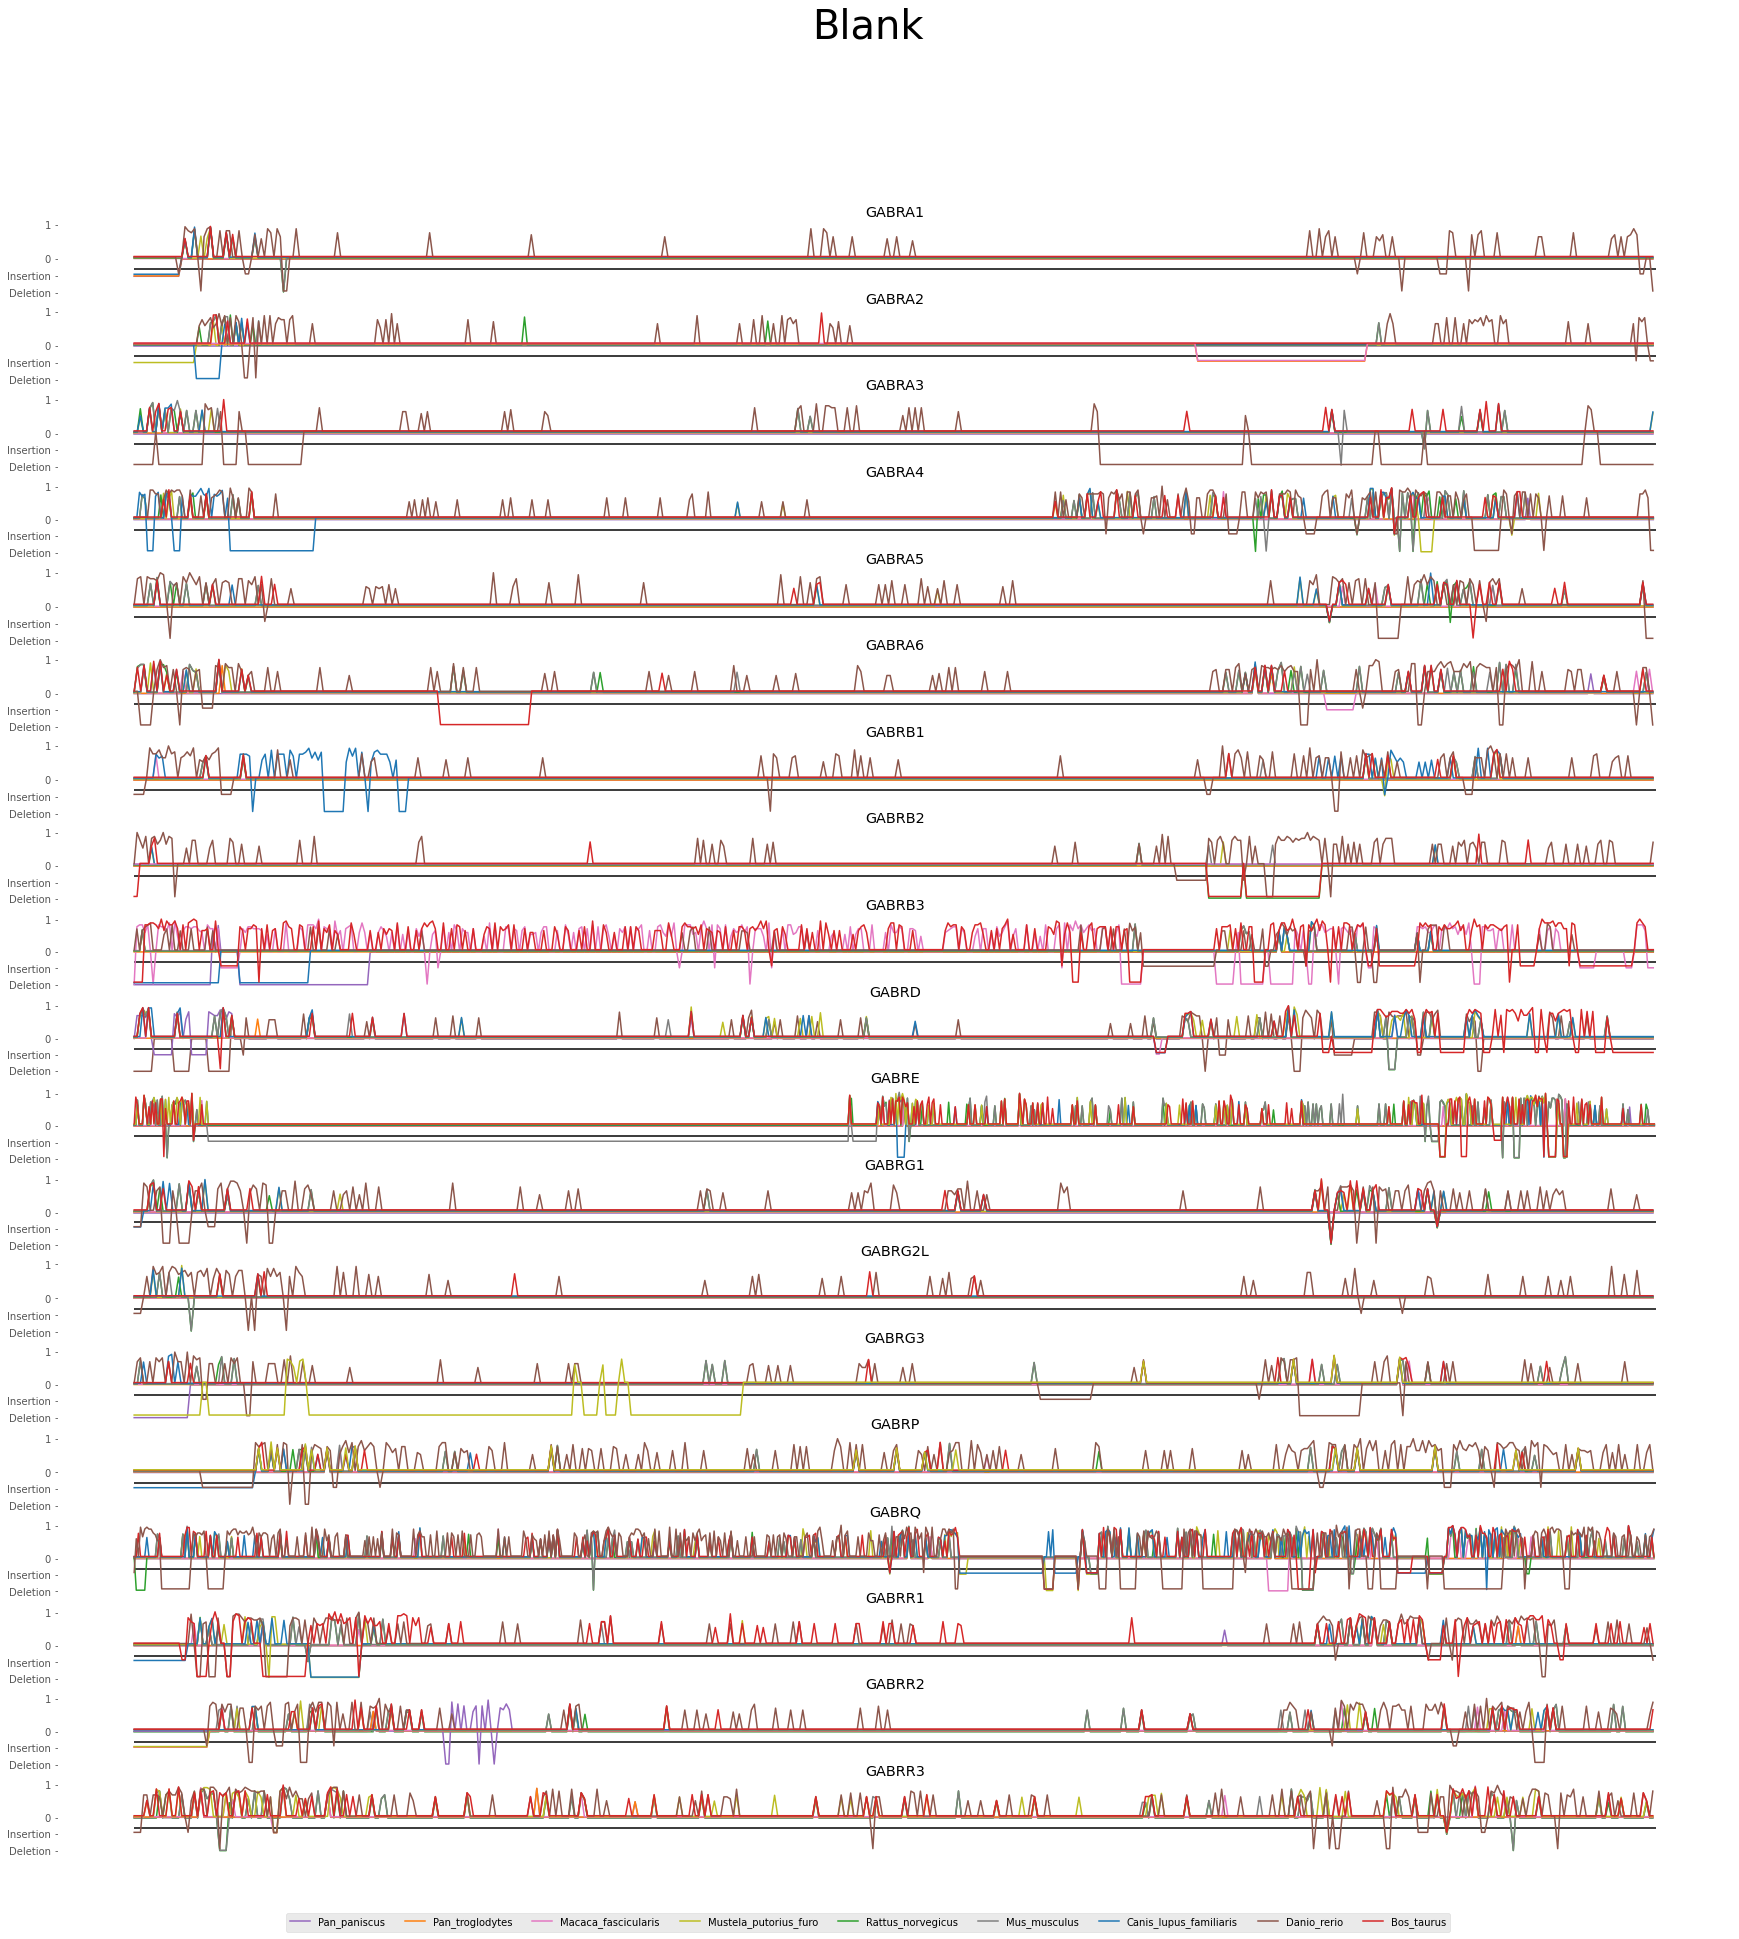

In [350]:
color_names = set(y for x in comparisons.values() for y in x.keys())
cmap = pyplot.get_cmap("tab10")
colors = {name: color for name, color in zip(color_names, numpy.apply_along_axis(matplotlib.colors.rgb2hex, 1, cmap(numpy.arange(len(color_names)))))}

dict_to_plot(comparisons, ticks=False, colors=colors, title="Blank")

In [320]:
# Cutoff AA for ECD vs the rest - unified across all the subunits through a comon alignment
ecd_cutoff = {"GABRA1": ("K", 249),
              "GABRA2": ("K", 249),
              "GABRA3": ("K", 274),
              "GABRA4": ("K", 255),
              "GABRA5": ("K", 256),
              "GABRA6": ("K", 239),
              "GABRB1": ("N", 242),
              "GABRB2": ("N", 241),
              "GABRB3": ("N", 242),
              "GABRD" : ("N", 246),
              "GABRE" : ("R", 276),
              "GABRG1": ("R", 269),
              "GABRG2L": ("R", 271),
              "GABRG3": ("R", 252),
              "GABRP" : ("N", 241),
              "GABRQ" : ("E", 264),
              "GABRR1": ("H", 280),
              "GABRR2": ("H", 260),
              "GABRR3": ("H", 266),}

# Transform the numbers into the correct ones for each alignment
def find_cutoff_number(sequence, aa, aa_number):
    j = 0
    for i, sequence_aa in enumerate(sequence):
        if sequence_aa != "-":
            j += 1
            if j == aa_number and sequence_aa == aa:
                return i

ecd_cutoff_ali = {}
for key, (aa, aa_number) in ecd_cutoff.items():
    for sequence in alignments[key]:
        if "Homo_sapiens" in sequence.id:
            break
    ecd_cutoff_ali[key] = find_cutoff_number(sequence, aa, aa_number)

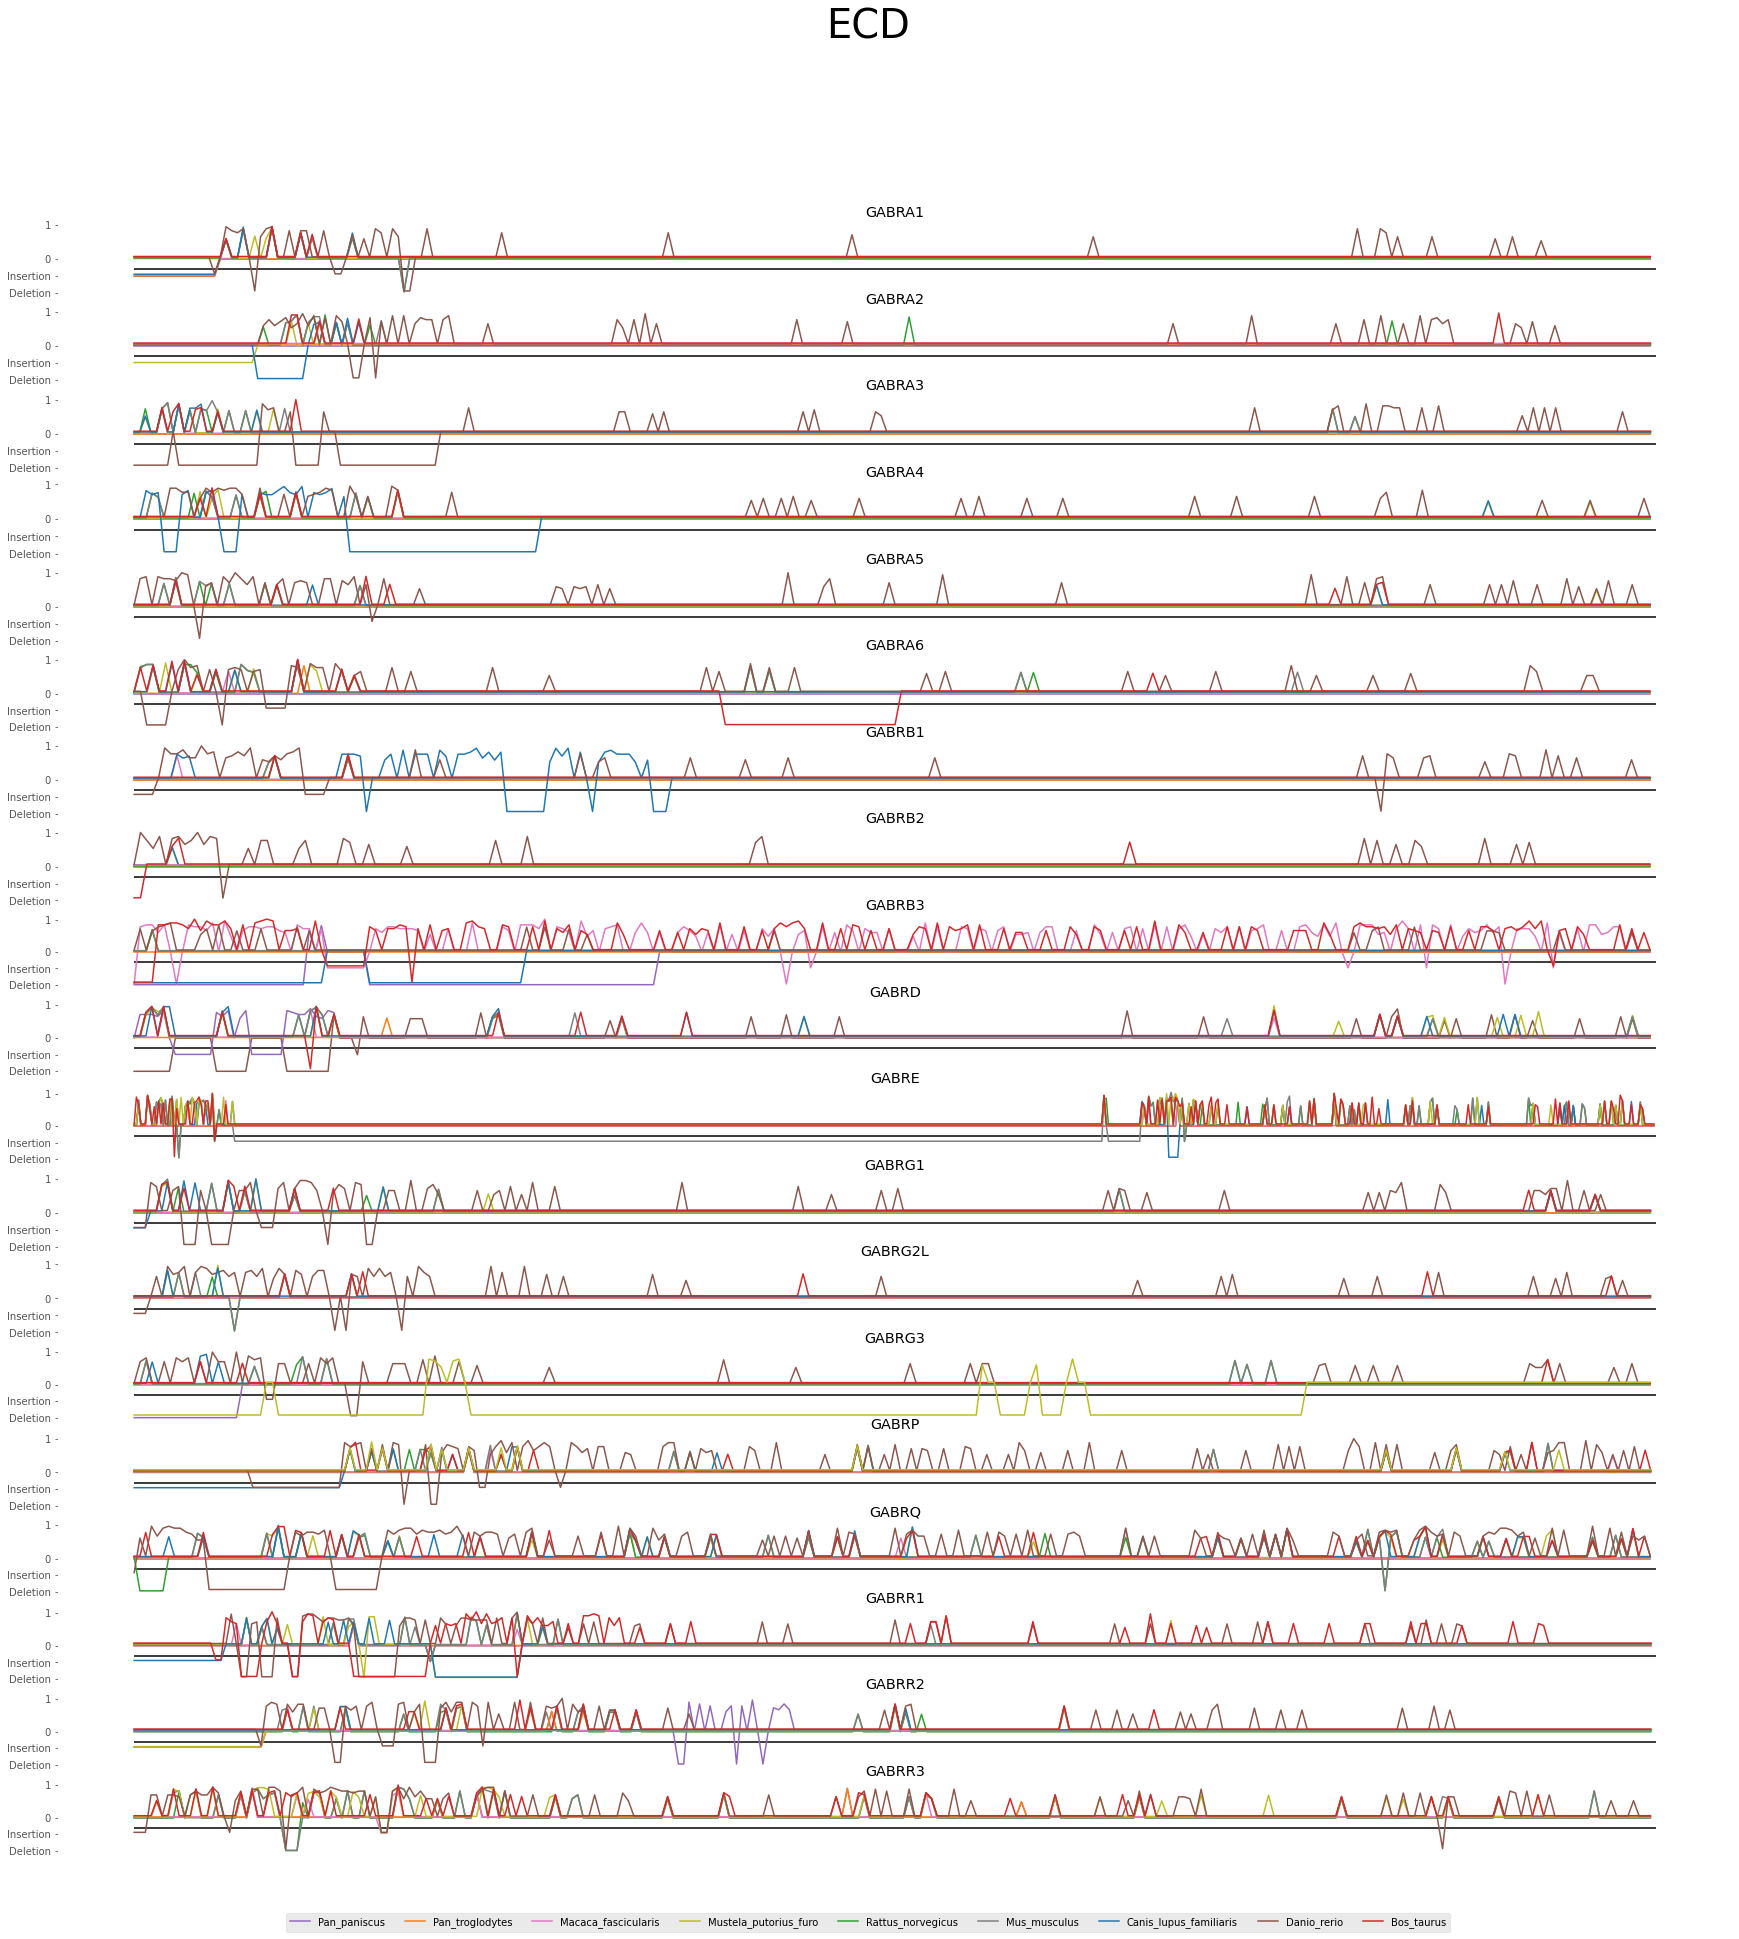

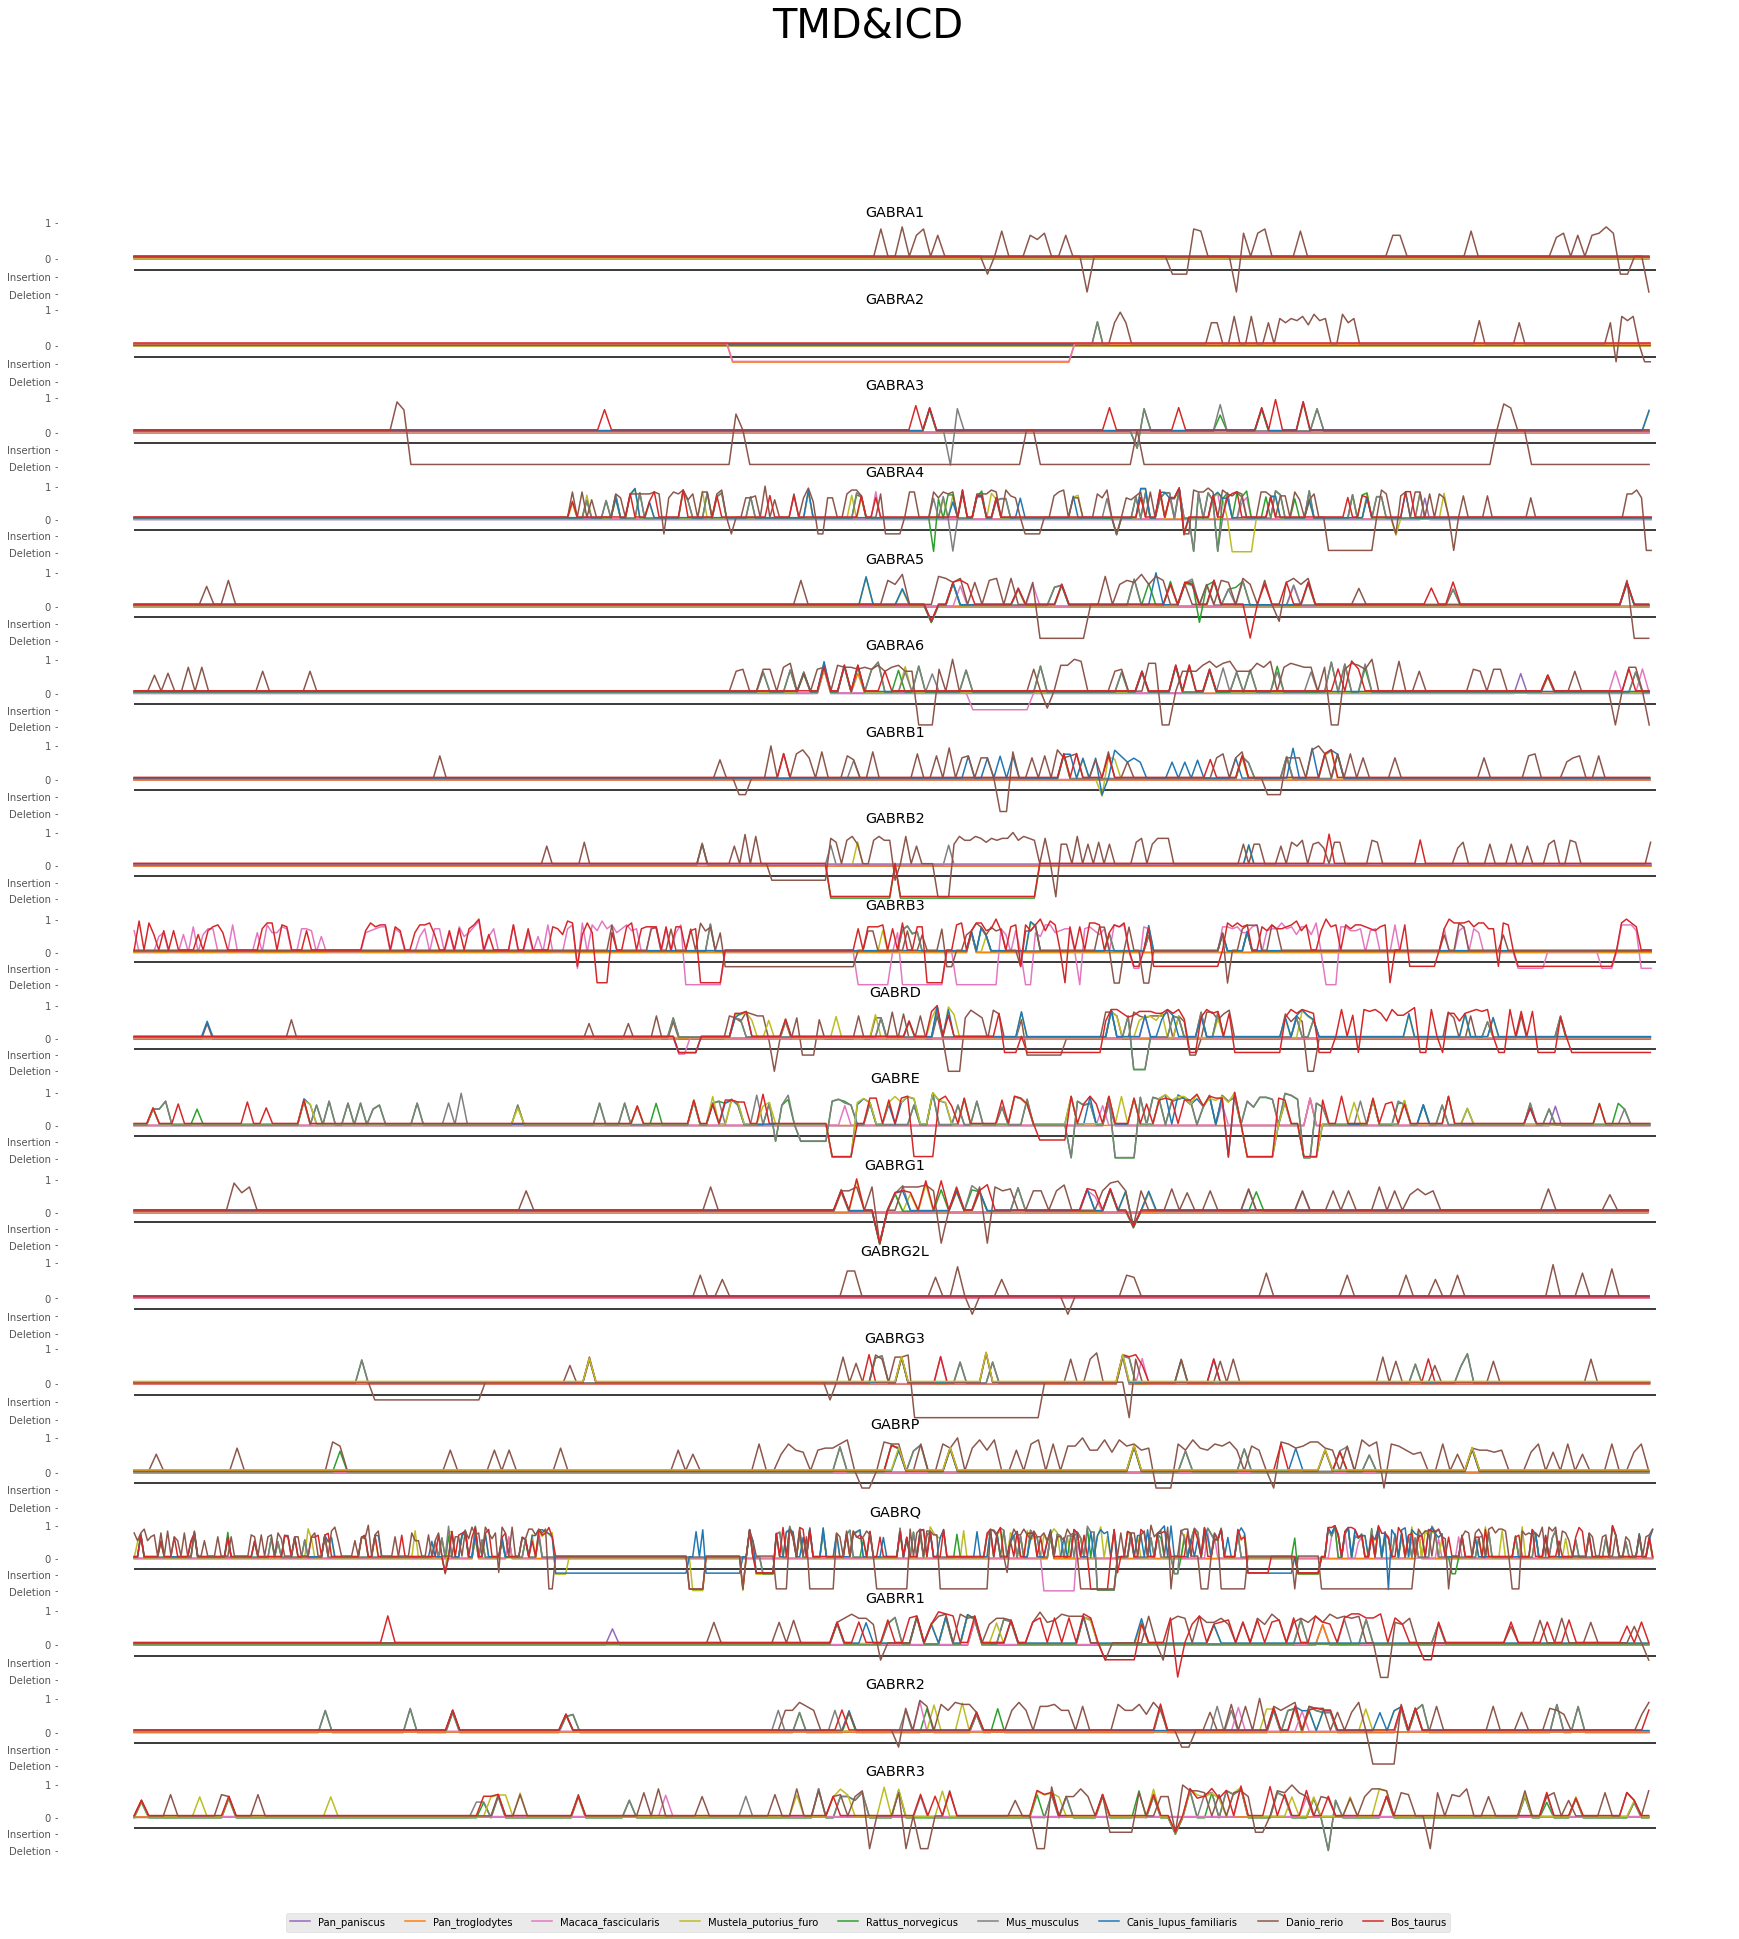

In [351]:
color_names = set(y for x in comparisons.values() for y in x.keys())
cmap = pyplot.get_cmap("tab10")
colors = {name: color for name, color in zip(color_names, numpy.apply_along_axis(matplotlib.colors.rgb2hex, 1, cmap(numpy.arange(len(color_names)))))}

comparisons_ecd =  {key: {subkey: comparisons[key][subkey][:i] for subkey in comparisons[key].keys()} for key, i in ecd_cutoff_ali.items()}
comparisons_rest = {key: {subkey: comparisons[key][subkey][i:] for subkey in comparisons[key].keys()} for key, i in ecd_cutoff_ali.items()}

dict_to_plot(comparisons_ecd, ticks=False, colors=colors, title="ECD")
dict_to_plot(comparisons_rest, ticks=False, colors=colors, title="TMD&ICD")